In [1]:
pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2
from ultralytics import YOLO
#import numpy as np
import matplotlib.pyplot as plt


In [3]:
model = YOLO("best5.pt")

In [10]:
# Path to your test image (change this to your own image path)
image_path = "Car.jpg"

# Run detection
results = model(image_path, conf=0.095)  # confidence threshold 50%

# results[0] contains detections for the first (and only) image
results[0].show()   # OpenCV popup (if supported)


image 1/1 c:\Users\Matthew\Documents\dspCPE4A2526\dspPython\Car.jpg: 512x640 1 Template, 450.1ms
Speed: 3.2ms preprocess, 450.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


In [6]:
pip install pytesseract

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


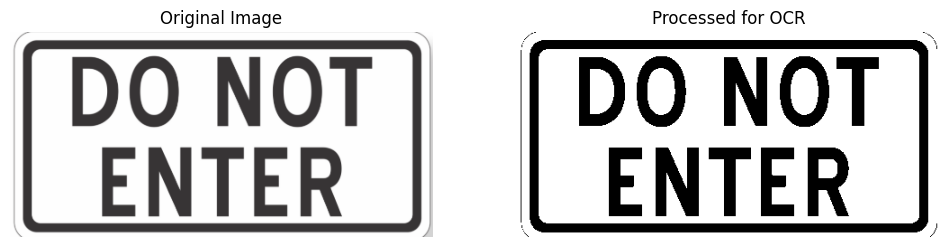

Extracted Text:
 


In [7]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

# --- OPTIONAL: If tesseract is not in PATH, set the path manually ---
# For Windows, uncomment and adjust:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

def ocr_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    _, thresh = cv2.threshold(gray, 170, 200, cv2.THRESH_BINARY)

    # Morphological noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # OCR with Tesseract
    text = pytesseract.image_to_string(cleaned)

    # Show original and processed image inline (Jupyter)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(cleaned, cmap="gray")
    axs[1].set_title("Processed for OCR")
    axs[1].axis("off")

    plt.show()

    return text


# Example usage
text_output = ocr_image("Sampletxt.png")
print("Extracted Text:\n", text_output)



0: 480x640 5 Templates, 1015.4ms
Speed: 5.2ms preprocess, 1015.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


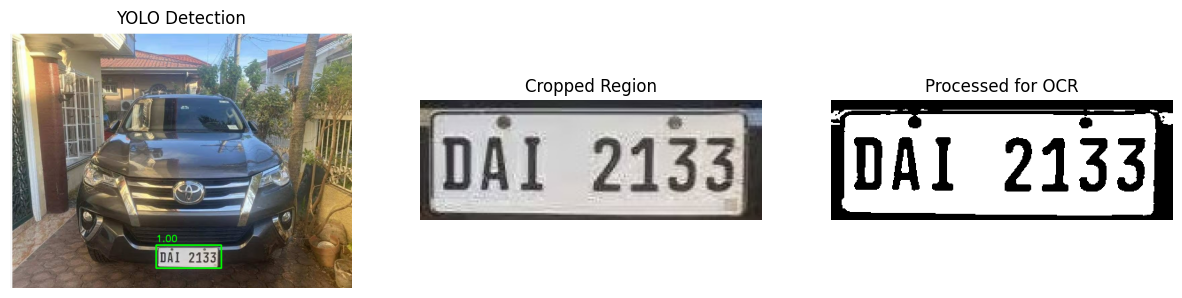

Extracted Text: DAI2133
Detection Confidence: 1.00


In [ ]:
import cv2
import pytesseract
from ultralytics import YOLO
import matplotlib.pyplot as plt
import re

model = YOLO("best5.pt") 

def detect_and_ocr(image_path):
    img = cv2.imread(image_path)
    results = model(img)

    best_crop, best_conf = None, 0
    x1 = y1 = x2 = y2 = 0  

    for r in results:
        for box in r.boxes:
            conf = float(box.conf[0])
            if conf > best_conf:
                best_conf = conf
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                best_crop = img[y1:y2, x1:x2]

    plate_text = ""
    if best_crop is not None:
        gray = cv2.cvtColor(best_crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        raw = pytesseract.image_to_string(
            thresh,
            config="--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        ).strip().upper()

        cleaned = re.sub(r"[^A-Z0-9]", "", raw)
        match = re.search(r"[A-Z]{3}[0-9]{3,4}", cleaned)
        plate_text = match.group(0) if match else cleaned

        fig, axs = plt.subplots(1, 3, figsize=(15, 6))

        img_box = img.copy()
        cv2.rectangle(img_box, (x1, y1), (x2, y2), (0, 255, 0), 3)
        label = f"{best_conf:.2f}"
        cv2.putText(img_box, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        axs[0].imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
        axs[0].set_title("YOLO Detection")
        axs[0].axis("off")

        axs[1].imshow(cv2.cvtColor(best_crop, cv2.COLOR_BGR2RGB))
        axs[1].set_title("Cropped Region")
        axs[1].axis("off")

        axs[2].imshow(thresh, cmap="gray")
        axs[2].set_title("Processed for OCR")
        axs[2].axis("off")

        plt.show()

    return plate_text, best_conf

result_text, confidence = detect_and_ocr("Car2.jpg")
print(f"Extracted Text: {result_text}")
print(f"Detection Confidence: {confidence:.2f}")
